In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import tensorflow as tf

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

## Parameters

In [5]:
NSAMPLE = 2500

In [6]:
from aml_dl.mdn.training.config import network_params_inv

AML_DATA environment variable is not set.
Training data folder does not exist...


In [7]:
from aml_dl.mdn.model.mdn_push_inv_model import MDNPushInverseModel

In [8]:
sess = tf.InteractiveSession()

In [9]:
inverse_model = MDNPushInverseModel(sess=sess, network_params=network_params_inv)
inverse_model.init_model()

In [10]:
x_curr   = np.random.randn(1,7).tolist()[0]
x_tgt    = np.random.randn(1,7).tolist()[0]
u_action = np.random.random((1,2))

In [11]:
input_x = np.expand_dims(np.r_[x_curr, x_tgt], 0)
mus = inverse_model.run_op('mu', input_x)[0]
sigma = inverse_model.run_op('sigma', input_x)[0]
pis = inverse_model.run_op('pi', input_x)[0]
loss = inverse_model._mdn.run_op(sess,'loss', xs = input_x, ys = u_action)[0]

print "MUS: ", mus
print "SIGMA: ", sigma
print "PIs:", pis
print "LOSS:", loss
#theta = inverse_model.sample_out_max_pi(input_x, 1)[0]
    
pi_idx = inverse_model._max_pi_idx(pis)

action = mus[:,pi_idx]


MUS:  [[ 0.06582622 -0.11802301 -0.24407315  0.10432126 -0.01859729]
 [ 0.10311697  0.03410589  0.08591975  0.2365827  -0.06807314]]
SIGMA:  [ 1.07216394  0.88884181  0.92687178  1.40833282  0.88898605]
PIs: [ 0.25814223  0.22832127  0.16151164  0.19171064  0.1603142 ]
LOSS: [[ 2.09110832]]


In [12]:
network_params_inv['dim_input'] = 14
network_params_inv['dim_output'] = 2
network_params_inv['k_mixtures'] = 24

inverse_model = MDNPushInverseModel(sess=sess, network_params=network_params_inv)
inverse_model.init_model()

In [13]:
xs = np.random.uniform(-10.5, 10.5, (14, NSAMPLE)).T
ys = np.random.uniform(-10.5, 10.5, (2, NSAMPLE)).T

In [ ]:
sess.run(tf.global_variables_initializer())

NEPOCH = 10000
loss = np.zeros(NEPOCH) # store the training progress here.
for i in range(NEPOCH):
  sess.run(inverse_model._net_ops['train'],feed_dict={inverse_model._net_ops['x']: xs, inverse_model._net_ops['y']: ys})
  loss[i] = sess.run(inverse_model._net_ops['loss'], feed_dict={inverse_model._net_ops['x']: xs, inverse_model._net_ops['y']: ys})

In [ ]:
print loss

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, NEPOCH,1), loss[100:], 'r-')
plt.show()

In [15]:
from aml_dl.mdn.model.tf_mdn_model import MixtureOfGaussians

In [16]:
out_pi = inverse_model._net_ops['pi']
out_sigma = inverse_model._net_ops['sigma']
out_mu = inverse_model._net_ops['mu']
x = inverse_model._net_ops['x']

In [17]:
mixture = MixtureOfGaussians()

In [18]:
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector


In [19]:
out_pi_test, out_sigma_test, out_mu_test = sess.run([out_pi, out_sigma, out_mu], feed_dict={x: x_test})

In [20]:
# print out_mu_test.reshape((300,2))

In [22]:
out_mu_test = out_mu_test.reshape((300,24))
print out_pi_test.shape, x_test.shape, out_sigma_test.shape, out_mu_test.shape


(300, 24) (300, 1) (300, 24) (300, 24)


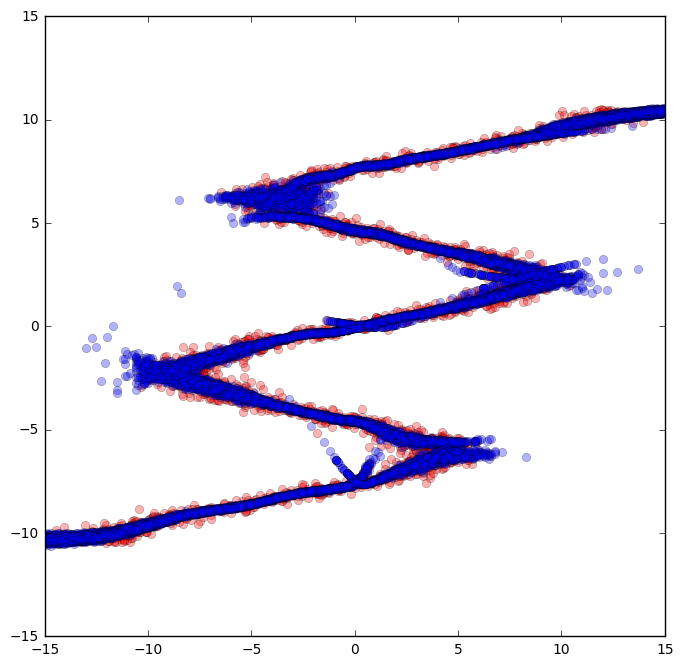

In [23]:


y_test = mixture.generate_mixture_samples(out_pi_test, out_mu_test, out_sigma_test,100)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()